## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import LayerNormalization, GRU
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Dropout, PReLU, Embedding
from tensorflow.keras.layers import Bidirectional, LSTM, Input
from tensorflow.keras.layers import GlobalMaxPool1D, Concatenate

## Define hardware config

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    MINI_BATCH_SIZE = strategy.num_replicas_in_sync * 32
    print("Running on TPU:", tpu.master())
    print(f'batch size: {MINI_BATCH_SIZE}')
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    MINI_BATCH_SIZE = 256
    print(f"Running on {strategy.num_replicas_in_sync} replica")
    print(f'batch size: {MINI_BATCH_SIZE}')

Running on TPU: grpc://10.0.0.2:8470
batch size: 256


## Load source datasets

In [3]:
with open("../input/mh-new-dawn/MH_New_Dawn_Set1.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_word_sequences = processed_data['train_word_sequences']
test_word_sequences = processed_data['test_word_sequences']
nb_words = processed_data['nb_words']
MAX_LEN = processed_data['MAX_LEN']

del processed_data
gc.collect()

42

In [4]:
with open("../input/mh-new-dawn/MH_New_Dawn_Set2.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
Xtrain = processed_data['Xtrain']
Xtest = processed_data['Xtest']
Ytrain = processed_data['Ytrain']
Ytrain_oh = processed_data['Ytrain_oh']
class_weight = processed_data['class_weight']

del processed_data
gc.collect()

20

In [5]:
selected_cols = [col for col in Xtrain.columns if not(col.startswith('glove') or col.startswith('fasttext') or col.startswith('para'))]
Xtrain = Xtrain[selected_cols].copy()
Xtest = Xtest[selected_cols].copy()
print(f"Xtrain: {Xtrain.shape} \nXtest: {Xtest.shape}")

Xtrain: (44095, 26) 
Xtest: (18900, 26)


In [6]:
with open("../input/mh-new-dawn/MH_New_Dawn_Set3.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
embedding_matrix = processed_data['embedding_matrix4']

del processed_data
gc.collect()

40

## Build and validate the model

In [7]:
def build_model(embedding_matrix, nb_words, n_features, embedding_size=300, seed=0):
    
    x_input1 = Input(shape=(MAX_LEN,))
    x_input2 = Input(shape=(n_features,))
    
    embed = Embedding(nb_words, embedding_size, 
                      weights=[embedding_matrix], 
                      trainable=False, 
                      embeddings_initializer=LecunNormal(seed=seed))(x_input1)
    embed = LayerNormalization(epsilon=1e-5)(embed)
    
    x1 = Bidirectional(LSTM(units=96, activation='tanh',
                            return_sequences=True, dropout=0.25,
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer=LecunNormal(seed=seed)))(embed)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x2 = Bidirectional(GRU(units=48, activation='tanh',
                           return_sequences=True, dropout=0.25,
                           kernel_regularizer=l2(0.0001),
                           kernel_initializer=LecunNormal(seed=seed)))(x1)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    
    avg_pool1 = GlobalAveragePooling1D()(x1)
    avg_pool2 = GlobalAveragePooling1D()(x2)
    
    max_pool1 = GlobalMaxPool1D()(x1)
    max_pool2 = GlobalMaxPool1D()(x2)
    
    x3 = Dense(units=48, kernel_initializer=LecunNormal(seed=seed), 
               kernel_regularizer=l2(0.0003))(x_input2)
    x3 = PReLU()(x3)
    x3 = BatchNormalization()(x3)
    
    x4 = Concatenate()([avg_pool1, avg_pool2, max_pool1, max_pool2])
    x4 = BatchNormalization()(x4)
    x5 = Dropout(rate=0.35)(x4)
    
    x5 = Dense(units=96, kernel_initializer=LecunNormal(seed=seed), 
               kernel_regularizer=l2(0.0003))(x5)
    x5 = PReLU()(x5)
    x5 = BatchNormalization()(x5)
    
    x = Concatenate()([x5, x3, x4])
    x = BatchNormalization()(x)
    x = Dropout(rate=0.35)(x)
    
    x = Dense(units=32, kernel_initializer=LecunNormal(seed=seed), 
              kernel_regularizer=l2(0.0001))(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)
    
    x = Dense(units=3, activation='softmax', 
              kernel_initializer=LecunNormal(seed=seed))(x)
    
    model = Model(inputs=[x_input1, x_input2], outputs=x, 
                  name='MachineHack_Sentiment_Analysis_Model')
    return model

In [8]:
model = build_model(embedding_matrix, nb_words, Xtrain.shape[1], embedding_size=300)
model.summary()

Model: "MachineHack_Sentiment_Analysis_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1840)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1840, 300)    22963200    input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 1840, 300)    600         embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1840, 192)    304896      layer_normalization[0][0]        
_______________________________________________________________

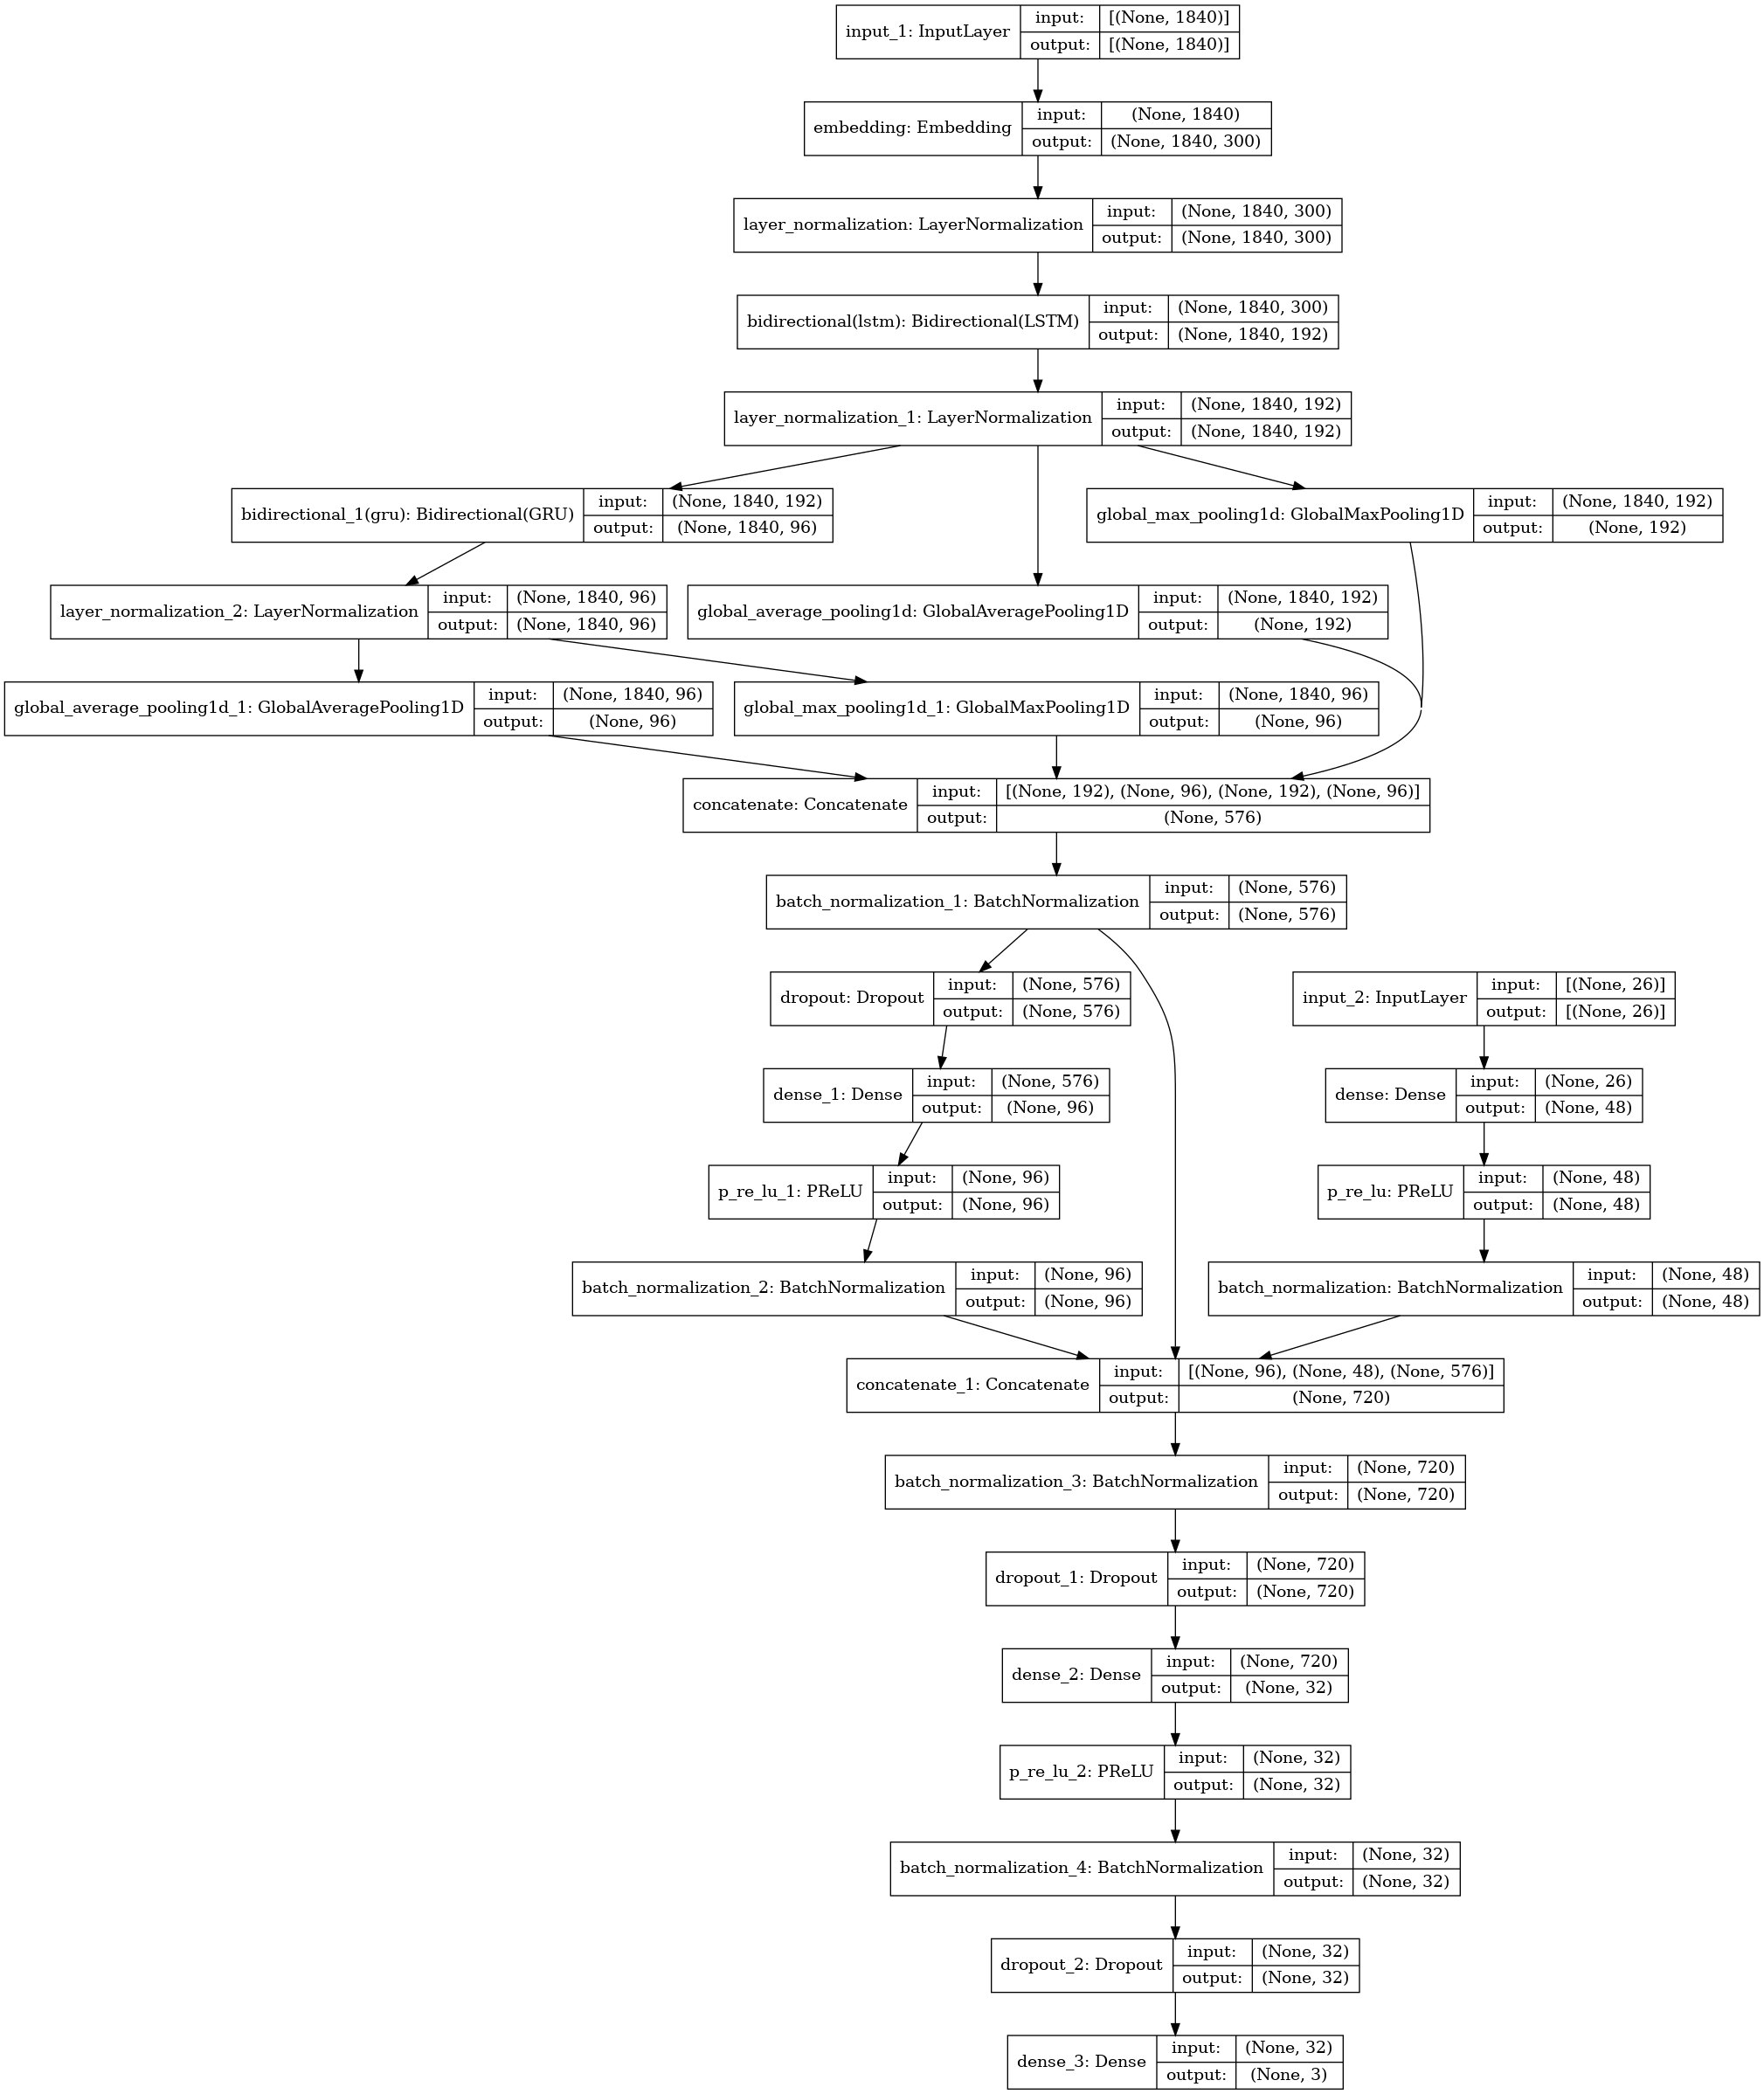

In [9]:
plot_model(
    model, to_file='./MachineHack_Sentiment_Analysis_Model.png', 
    show_shapes=True, show_layer_names=True
)

In [10]:
FOLD = 5
VERBOSE = 1
SEEDS = [2020, 2022]

counter = 0
oof_score = 0
y_pred_meta_dnn = np.zeros((Xtrain.shape[0], 3))
y_pred_final_dnn = np.zeros((Xtest.shape[0], 3))

In [11]:
with strategy.scope():

    for sidx, seed in enumerate(SEEDS):
        seed_score = 0

        kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

        for idx, (train, val) in enumerate(kfold.split(train_word_sequences, Ytrain)):
            counter += 1

            train_x1, train_y, train_y_oh = train_word_sequences[train], Ytrain[train], Ytrain_oh[train]
            val_x1, val_y, val_y_oh = train_word_sequences[val], Ytrain[val], Ytrain_oh[val]
            train_x2, val_x2 = Xtrain.iloc[train], Xtrain.iloc[val]

            tf.random.set_seed(seed+idx)

            model = build_model(embedding_matrix, 
                                nb_words, 
                                Xtrain.shape[1], 
                                embedding_size=300, 
                                seed=(seed+idx))

            model.compile(loss='categorical_crossentropy',
                          optimizer=Adamax(lr=8e-3))

            early = EarlyStopping(monitor="val_loss", mode="min", 
                                  restore_best_weights=True, 
                                  patience=10, verbose=VERBOSE)

            reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.25, 
                                          min_lr=1e-6, patience=4, 
                                          verbose=VERBOSE, mode='min')

            chk_point = ModelCheckpoint('./MachineHack_Sentiment_Analysis_Model1.h5', 
                                        monitor='val_loss', verbose=VERBOSE, 
                                        save_best_only=True, mode='min',
                                        save_weights_only=True)

            history = model.fit(
                [train_x1, train_x2], train_y_oh, 
                batch_size=MINI_BATCH_SIZE,
                epochs=100, 
                verbose=VERBOSE, 
                #class_weight=class_weight, 
                callbacks=[reduce_lr, early, chk_point], 
                validation_data=([val_x1, val_x2], val_y_oh)
            )

            model.load_weights(f'./MachineHack_Sentiment_Analysis_Model1.h5')

            y_pred = model.predict([val_x1, val_x2], batch_size=MINI_BATCH_SIZE)
            y_pred_meta_dnn[val] += y_pred
            y_pred_final_dnn += model.predict([test_word_sequences, Xtest], batch_size=MINI_BATCH_SIZE)
            
            score = log_loss(val_y_oh, y_pred)
            oof_score += score
            seed_score += score
            print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
            
        print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))

Epoch 1/100
138/138 [==============================] - 61s 303ms/step - loss: 1.1138 - val_loss: 0.9495

Epoch 00001: val_loss improved from inf to 0.94955, saving model to ./MachineHack_Sentiment_Analysis_Model1.h5
Epoch 2/100
138/138 [==============================] - 31s 223ms/step - loss: 0.8455 - val_loss: 0.9012

Epoch 00002: val_loss improved from 0.94955 to 0.90115, saving model to ./MachineHack_Sentiment_Analysis_Model1.h5
Epoch 3/100
138/138 [==============================] - 31s 223ms/step - loss: 0.7952 - val_loss: 0.8255

Epoch 00003: val_loss improved from 0.90115 to 0.82554, saving model to ./MachineHack_Sentiment_Analysis_Model1.h5
Epoch 4/100
138/138 [==============================] - 31s 223ms/step - loss: 0.7581 - val_loss: 0.8515

Epoch 00004: val_loss did not improve from 0.82554
Epoch 5/100
138/138 [==============================] - 31s 223ms/step - loss: 0.7316 - val_loss: 0.7655

Epoch 00005: val_loss improved from 0.82554 to 0.76555, saving model to ./MachineHa

In [12]:
y_pred_meta_dnn = y_pred_meta_dnn / float(len(SEEDS))
y_pred_final_dnn = y_pred_final_dnn / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Aggregate OOF Score: 0.6486890219951553


In [13]:
np.savez_compressed('./DNN_Meta_Features.npz',
                    y_pred_meta_dnn=y_pred_meta_dnn, 
                    oof_score=oof_score,
                    y_pred_final_dnn=y_pred_final_dnn)

## Create submission file

In [14]:
submit_df = pd.DataFrame(y_pred_final_dnn, columns=['Negative_0','Neutral_1','Positive_2'])
submit_df.to_csv("./submission.csv", index=False)
submit_df.head()

,Negative_0,Neutral_1,Positive_2
0,0.136113,0.087513,0.776375
1,0.750694,0.166822,0.082484
2,0.972894,0.001155,0.025951
3,0.844949,0.080463,0.074589
4,0.428232,0.470831,0.100937
